In [ ]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air/notebooks')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 24843
-rw------- 1 root root 5517847 Jun 11 14:58 '01 Result Data Cleaning Part 1.csv'
-rw------- 1 root root 1964974 Jun 11 14:58 '02 Data Preperation.ipynb'
-rw------- 1 root root  256098 Jun 11 14:58 '02 X_test.csv'
-rw------- 1 root root 4831129 Jun 11 14:58 '02 X_train.csv'
-rw------- 1 root root   40580 Jun 11 14:58 '02 y_test.csv'
-rw------- 1 root root  770651 Jun 11 14:58 '02 y_train.csv'
-rw------- 1 root root  322748 Jun 11 14:58 '03 ARIMA.ipynb'
-rw------- 1 root root    2277 Jun 11 14:58  03_Result_ARIMA.csv
-rw------- 1 root root 6247212 Jun 11 14:58  04c_ARIMA_Manggarai.ipynb
-rw------- 1 root root  631448 Jun 11 14:58  06_DataPreperation_ML.ipynb
-rw------- 1 root root 1611961 Jun 11 14:58  07a_best_model.keras
-rw------- 1 root root  371715 Jun 11 14:58  07a_LSTM_Manggarai.ipynb
-rw------- 1 root root 1685693 Jun 11 14:58  07b_best_model.keras
-rw------- 1 root root  368771 Jun 11 14:58  07b_LSTM_M

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style and random seed
plt.style.use('default')
np.random.seed(42)

In [3]:
X_train = pd.read_csv('02 X_train.csv', index_col='Tanggal', parse_dates=True)
X_test = pd.read_csv('02 X_test.csv', index_col='Tanggal', parse_dates=True)
y_train = pd.read_csv('02 y_train.csv', index_col='Tanggal', parse_dates=True).squeeze()
y_test = pd.read_csv('02 y_test.csv', index_col='Tanggal', parse_dates=True).squeeze()

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nFeatures: {list(X_train.columns)}")


X_train shape: (29640, 30)
X_test shape: (1560, 30)

y_train shape: (29640,)
y_test shape: (1560,)

Features: ['time_index', 'hour_sin', 'hour_cos', 'manggarai_air_lag1', 'manggarai_air_lag2', 'manggarai_air_lag3', 'manggarai_air_lag4', 'manggarai_air_lag5', 'manggarai_air_lag6', 'depok_air_lag6', 'depok_air_lag7', 'depok_air_lag8', 'depok_air_lag9', 'katulampa_air_lag11', 'katulampa_air_lag12', 'katulampa_air_lag13', 'manggarai_cuaca_hujan', 'manggarai_cuaca_lag1_hujan', 'manggarai_cuaca_lag2_hujan', 'manggarai_cuaca_lag3_hujan', 'manggarai_cuaca_lag4_hujan', 'manggarai_cuaca_lag5_hujan', 'manggarai_cuaca_lag6_hujan', 'depok_cuaca_lag6_hujan', 'depok_cuaca_lag7_hujan', 'depok_cuaca_lag8_hujan', 'depok_cuaca_lag9_hujan', 'katulampa_cuaca_lag11_hujan', 'katulampa_cuaca_lag12_hujan', 'katulampa_cuaca_lag13_hujan']


In [4]:
exog_columns = [
    'manggarai_air_lag1', 'manggarai_air_lag2','manggarai_air_lag3','manggarai_air_lag4','manggarai_air_lag5','depok_air_lag8','depok_air_lag7', 'depok_air_lag6', 'katulampa_air_lag11'
]

X_train_reduced = X_train[exog_columns]
X_test_reduced = X_test[exog_columns]

print(X_train_reduced.head())
print(X_test_reduced.head())

                     manggarai_air_lag1  manggarai_air_lag2  \
Tanggal                                                       
2021-10-17 00:00:00               565.0               565.0   
2021-10-17 01:00:00               590.0               565.0   
2021-10-17 02:00:00               575.0               590.0   
2021-10-17 03:00:00               570.0               575.0   
2021-10-17 04:00:00               565.0               570.0   

                     manggarai_air_lag3  manggarai_air_lag4  \
Tanggal                                                       
2021-10-17 00:00:00               565.0               600.0   
2021-10-17 01:00:00               565.0               565.0   
2021-10-17 02:00:00               565.0               565.0   
2021-10-17 03:00:00               590.0               565.0   
2021-10-17 04:00:00               575.0               590.0   

                     manggarai_air_lag5  depok_air_lag8  depok_air_lag7  \
Tanggal                                  

In [5]:
del X_train, X_test

# Baseline Model of the Grid Search

In [6]:
fixed_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1,
}

In [7]:
baseline_start = datetime.now()
baseline_model = xgb.XGBRegressor(**fixed_params)
baseline_model.fit(X_train_reduced, y_train)
baseline_time = datetime.now() - baseline_start

baseline_train_pred = baseline_model.predict(X_train_reduced)
baseline_test_pred = baseline_model.predict(X_test_reduced)

# Calculate metrics for training set
baseline_train_rmse = np.sqrt(mean_squared_error(y_train, baseline_train_pred))
baseline_train_mae = mean_absolute_error(y_train, baseline_train_pred)
baseline_train_r2 = r2_score(y_train, baseline_train_pred)
baseline_train_mape = mean_absolute_percentage_error(y_train, baseline_train_pred)

# Calculate metrics for test set
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, baseline_test_pred))
baseline_test_mae = mean_absolute_error(y_test, baseline_test_pred)
baseline_test_r2 = r2_score(y_test, baseline_test_pred)
baseline_test_mape = mean_absolute_percentage_error(y_test, baseline_test_pred)

print(f"Baseline completed in {baseline_time}")

print(f"Baseline Train RMSE: {baseline_train_rmse:.4f}")
print(f"Baseline Train MAE: {baseline_train_mae:.4f}")
print(f"Baseline Train R2: {baseline_train_r2:.4f}")
print(f"Baseline Train MAPE: {baseline_train_mape:.4f}")

print(f"Baseline Test RMSE: {baseline_test_rmse:.4f}")
print(f"Baseline Test MAE: {baseline_test_mae:.4f}")
print(f"Baseline Test R2: {baseline_test_r2:.4f}")
print(f"Baseline Test MAPE: {baseline_test_mape:.4f}")

Baseline completed in 0:00:12.283273
Baseline Train RMSE: 12.4398
Baseline Train MAE: 3.0363
Baseline Train R2: 0.9249
Baseline Train MAPE: 0.0094
Baseline Test RMSE: 24.5007
Baseline Test MAE: 4.7607
Baseline Test R2: 0.2827
Baseline Test MAPE: 0.0196


# Grid Search

In [8]:
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [300, 500],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.5, 1.0]
}

In [9]:
combinations = 1
for param, values in param_grid.items():
    combinations *= len(values)
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {combinations}")

  max_depth: [4, 6, 8]
  min_child_weight: [1, 3]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]
  learning_rate: [0.05, 0.1, 0.15]
  n_estimators: [300, 500]
  reg_alpha: [0.1, 0.5]
  reg_lambda: [0.5, 1.0]

Total combinations: 576


In [10]:
# Run grid search
base_model = xgb.XGBRegressor(**fixed_params)
grid_start = datetime.now()

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train_reduced, y_train)
grid_time = datetime.now() - grid_start

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300,

In [11]:
print(f"Grid search time: {grid_time}")
print(f"Best grid CV score: {-grid_search.best_score_:.4f}")
print(f"Best grid parameters: {grid_search.best_params_}")

Grid search time: 1:25:48.183686
Best grid CV score: 16.7604
Best grid parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 1.0}


In [12]:
grid_results_reduced_df = pd.DataFrame(grid_search.cv_results_)
grid_results_reduced_df.to_csv('08 grid_search_reduced_results.csv', index=False)

## Best Grid Search Model Performance

In [13]:
final_params = {**fixed_params, **grid_search.best_params_, 'early_stopping_rounds': 50}

print("Final parameters:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

Final parameters:
  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  random_state: 42
  n_jobs: -1
  verbosity: 1
  colsample_bytree: 1.0
  learning_rate: 0.05
  max_depth: 4
  min_child_weight: 3
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 1.0
  subsample: 1.0
  early_stopping_rounds: 50


In [16]:
# Train final model
final_start = datetime.now()
final_model = xgb.XGBRegressor(**final_params)
final_model.fit(
    X_train_reduced, y_train,
    eval_set=[(X_test_reduced, y_test)],
    verbose=False
)
final_training_time = datetime.now() - final_start

print(f"\nTraining completed in: {final_training_time}")
print(f"Best iteration: {final_model.best_iteration}")
print(f"Best score: {final_model.best_score:.4f}")


Training completed in: 0:00:02.011872
Best iteration: 52
Best score: 24.1272


In [21]:
# Make predictions
train_pred = final_model.predict(X_train_reduced)
test_pred = final_model.predict(X_test_reduced)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)

print("TRAINING SET METRICS:")
print(f"  RMSE: {train_rmse:.4f} cm")
print(f"  MAE:  {train_mae:.4f} cm")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape*100:.4f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test_rmse:.4f} cm")
print(f"  MAE:  {test_mae:.4f} cm")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape*100:.4f}%")

TRAINING SET METRICS:
  RMSE: 16.6750 cm
  MAE:  5.1320 cm
  R²:   0.8651
  MAPE: 1.7534%

TEST SET METRICS:
  RMSE: 24.1272 cm
  MAE:  5.2121 cm
  R²:   0.3044
  MAPE: 2.0285%


In [18]:
final_model.save_model('final_optimized_xgboost_model.json')


ADDITIONAL TEST METRICS:
  Mean Residual: 1.5214 cm
  Std Residual:  24.0792 cm
  Max Error:     597.7138 cm
Most Important Features:
            feature  importance
 manggarai_air_lag1    0.808308
 manggarai_air_lag4    0.049699
 manggarai_air_lag2    0.042134
     depok_air_lag7    0.027473
     depok_air_lag6    0.024384
 manggarai_air_lag5    0.018229
     depok_air_lag8    0.015703
 manggarai_air_lag3    0.011627
katulampa_air_lag11    0.002442


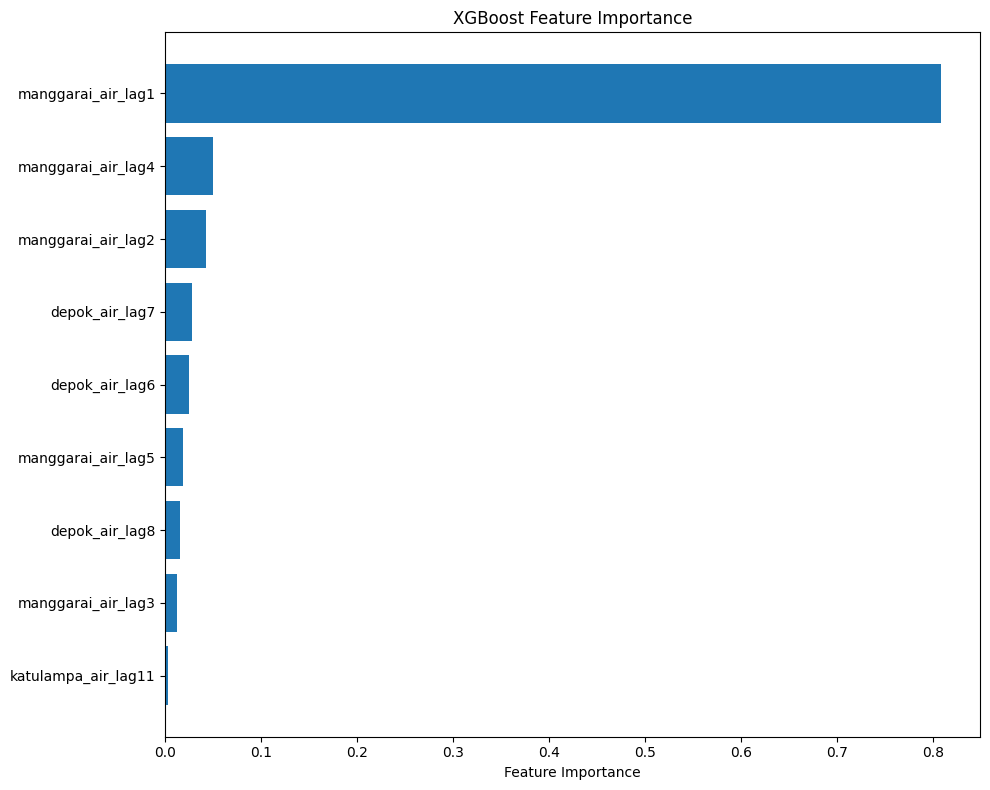

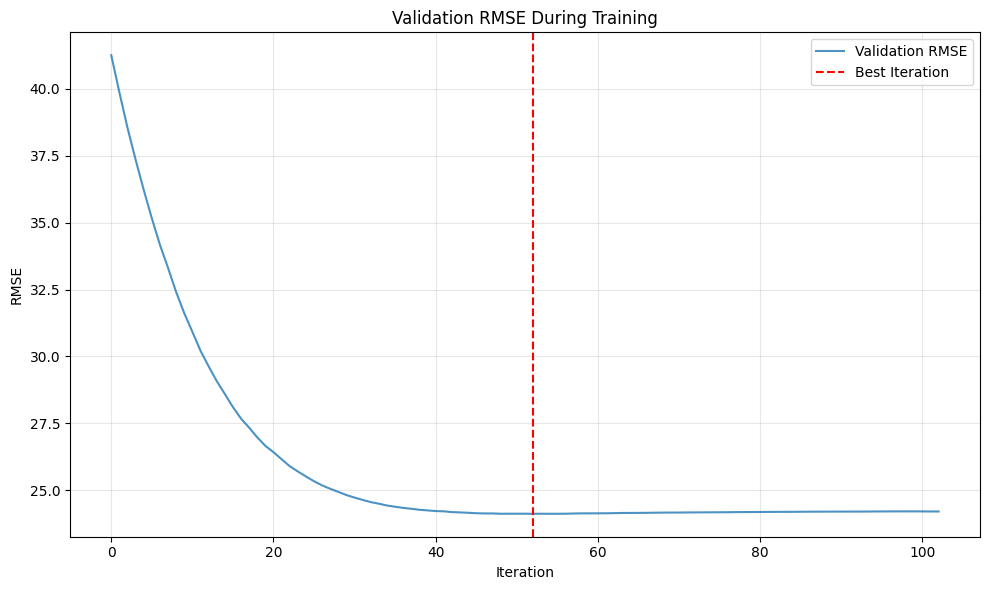

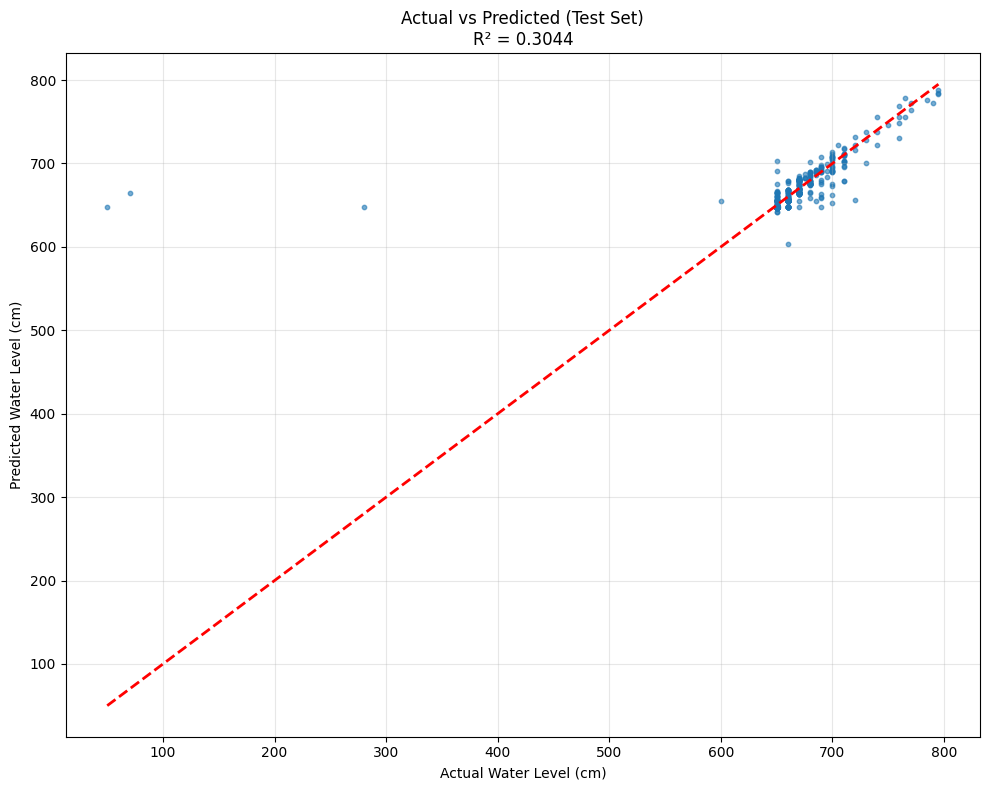

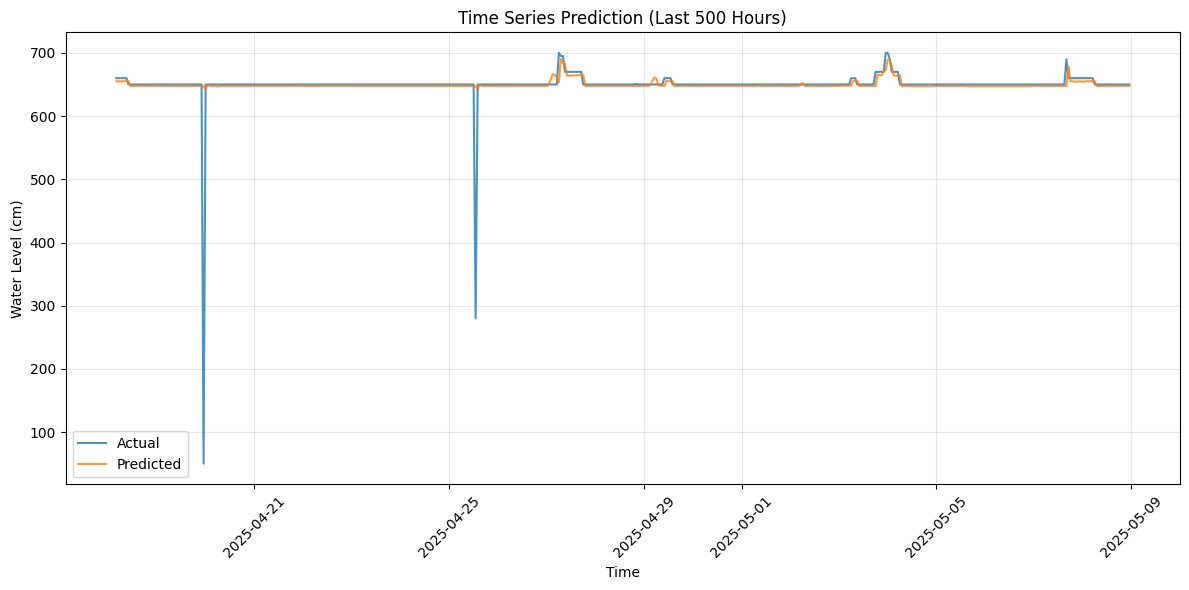

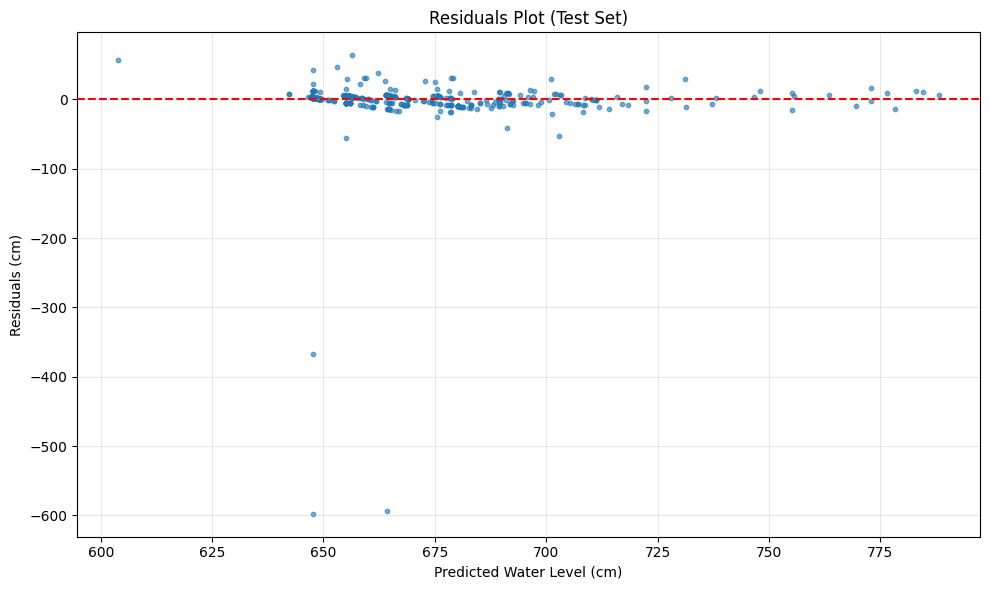

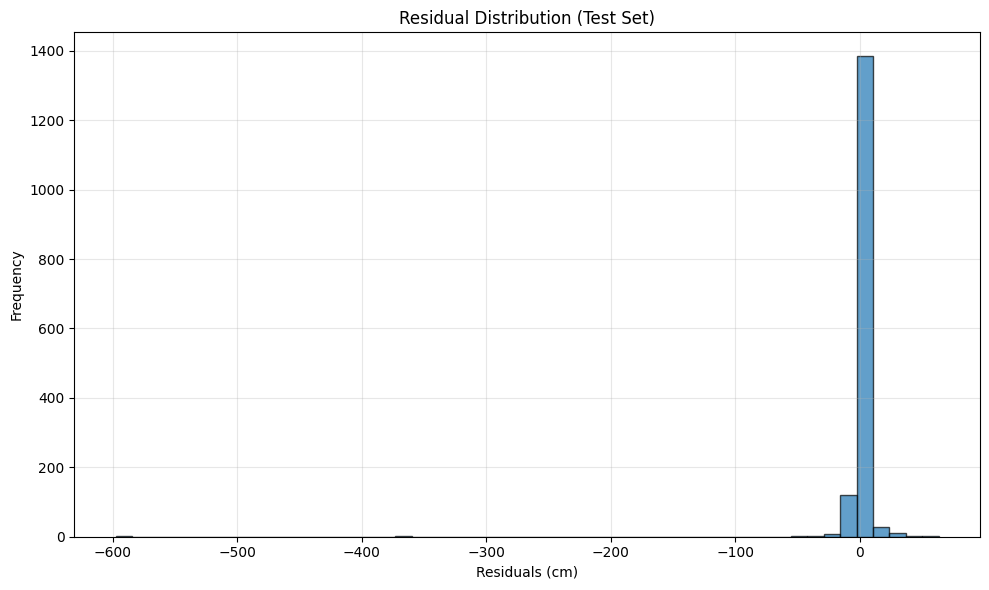

In [20]:
# Calculate additional metrics
residuals_test = y_test - test_pred
print(f"\nADDITIONAL TEST METRICS:")
print(f"  Mean Residual: {np.mean(residuals_test):.4f} cm")
print(f"  Std Residual:  {np.std(residuals_test):.4f} cm")
print(f"  Max Error:     {np.max(np.abs(residuals_test)):.4f} cm")

# =============================================================================
# Plot feature importance
# =============================================================================
feature_importance = pd.DataFrame({
    'feature': X_train_reduced.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Most Important Features:")
print(feature_importance.to_string(index=False))

plt.figure(figsize=(10, 8))
top_features = feature_importance
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
# =============================================================================
# PLOT 1: Training Validation Curve
# =============================================================================

plt.figure(figsize=(10, 6))
eval_results = final_model.evals_result()
if 'validation_0' in eval_results:
    plt.plot(eval_results['validation_0']['rmse'], label='Validation RMSE', alpha=0.8)
    plt.axvline(x=final_model.best_iteration, color='red', linestyle='--', label='Best Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Training progress\nnot available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Training Progress')

plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 2: Actual vs Predicted (Test Set)
# =============================================================================

plt.figure(figsize=(10, 8))
plt.scatter(y_test, test_pred, alpha=0.6, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Level (cm)')
plt.ylabel('Predicted Water Level (cm)')
plt.title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 3: Time Series Prediction (Last 500 Points)
# =============================================================================

plt.figure(figsize=(12, 6))
plot_points = min(500, len(y_test))
plt.plot(y_test.tail(plot_points), label='Actual', linewidth=1.5, alpha=0.8)
plt.plot(y_test.tail(plot_points).index, test_pred[-plot_points:],
         label='Predicted', linewidth=1.5, alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Water Level (cm)')
plt.title(f'Time Series Prediction (Last {plot_points} Hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 4: Residuals Plot
# =============================================================================

plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals_test, alpha=0.6, s=10)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Water Level (cm)')
plt.ylabel('Residuals (cm)')
plt.title('Residuals Plot (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 5: Residuals Histogram
# =============================================================================

plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (cm)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Level 2 Grid Search

In [32]:
level2_param_grid = {
    # Fine-tune max_depth around the optimal value (4)
    'max_depth': [3, 4, 5],
    
    # Fine-tune min_child_weight around optimal (3) 
    'min_child_weight': [2, 3, 4],
    
    # Fine-tune learning_rate around optimal (0.05)
    'learning_rate': [0.03, 0.04, 0.05, 0.06],
    
    # Fine-tune n_estimators around optimal (300)
    'n_estimators': [250, 300, 350, 400],
    
    # Fine-tune reg_alpha around optimal (0.1)
    'reg_alpha': [0.05, 0.1, 0.15, 0.2],

    # The best one from level 1 grid search
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'reg_lambda': [1.0]
}

In [33]:
combinations = 1
for param, values in level2_param_grid.items():
    combinations *= len(values)
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {combinations}")

  max_depth: [3, 4, 5]
  min_child_weight: [2, 3, 4]
  learning_rate: [0.03, 0.04, 0.05, 0.06]
  n_estimators: [250, 300, 350, 400]
  reg_alpha: [0.05, 0.1, 0.15, 0.2]
  subsample: [1.0]
  colsample_bytree: [1.0]
  reg_lambda: [1.0]

Total combinations: 576


In [35]:
# Run grid search
base_model = xgb.XGBRegressor(**fixed_params)
grid2_start = datetime.now()

grid2_search = GridSearchCV(
    estimator=base_model,
    param_grid=level2_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=2
)

grid2_search.fit(X_train_reduced, y_train)
grid2_time = datetime.now() - grid2_start

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=3, min_child_weight=2, n_estimators=250, reg_alpha=0.05, reg_lambda=1.0, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=3, min_child_weight=2, n_estimators=250, reg_alpha=0.05, reg_lambda=1.0, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=3, min_child_weight=2, n_estimators=250, reg_alpha=0.05, reg_lambda=1.0, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=3, min_child_weight=2, n_estimators=250, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=3, min_child_weight=2, n_estimators=250, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=3, min_child_weight=2, n_estimators=2

In [36]:
print(f"Grid search time: {grid2_time}")
print(f"Best grid CV score: {-grid2_search.best_score_:.4f}")
print(f"Best grid parameters: {grid2_search.best_params_}")

Grid search time: 1:04:54.002015
Best grid CV score: 16.5078
Best grid parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 250, 'reg_alpha': 0.15, 'reg_lambda': 1.0, 'subsample': 1.0}


In [37]:
grid_2_results_df = pd.DataFrame(grid2_search.cv_results_)
grid_2_results_df.to_csv('08 grid_search_2_results.csv', index=False)

## Best Grid Search Model Performance

In [38]:
grid2_final_params = {**fixed_params, **grid2_search.best_params_, 'early_stopping_rounds': 50}

print("Final parameters:")
for key, value in grid2_final_params.items():
    print(f"  {key}: {value}")

Final parameters:
  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  random_state: 42
  n_jobs: -1
  verbosity: 1
  colsample_bytree: 1.0
  learning_rate: 0.03
  max_depth: 3
  min_child_weight: 4
  n_estimators: 250
  reg_alpha: 0.15
  reg_lambda: 1.0
  subsample: 1.0
  early_stopping_rounds: 50


In [40]:
# Train final model
grid2_final_start = datetime.now()
grid2_final_model = xgb.XGBRegressor(**grid2_final_params)
grid2_final_model.fit(
    X_train_reduced, y_train,
    eval_set=[(X_test_reduced, y_test)],
    verbose=False
)
grid2_final_training_time = datetime.now() - grid2_final_start

print(f"\nTraining completed in: {grid2_final_training_time}")
print(f"Best iteration: {grid2_final_model.best_iteration}")
print(f"Best score: {grid2_final_model.best_score:.4f}")


Training completed in: 0:00:01.095385
Best iteration: 98
Best score: 24.2914


In [42]:
# Make predictions
train_pred_grid2 = final_model.predict(X_train_reduced)
test_pred_grid2 = final_model.predict(X_test_reduced)

# Calculate metrics for training set
train2_rmse = np.sqrt(mean_squared_error(y_train, train_pred_grid2))
train2_mae = mean_absolute_error(y_train, train_pred_grid2)
train2_r2 = r2_score(y_train, train_pred_grid2)
train2_mape = mean_absolute_percentage_error(y_train, train_pred_grid2)

# Calculate metrics for test set
test2_rmse = np.sqrt(mean_squared_error(y_test, test_pred_grid2))
test2_mae = mean_absolute_error(y_test, test_pred_grid2)
test2_r2 = r2_score(y_test, test_pred_grid2)
test2_mape = mean_absolute_percentage_error(y_test, test_pred_grid2)

print("TRAINING SET METRICS:")
print(f"  RMSE: {train2_rmse:.4f} cm")
print(f"  MAE:  {train2_mae:.4f} cm")
print(f"  R²:   {train2_r2:.4f}")
print(f"  MAPE: {train2_mape*100:.4f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test2_rmse:.4f} cm")
print(f"  MAE:  {test2_mae:.4f} cm")
print(f"  R²:   {test2_r2:.4f}")
print(f"  MAPE: {test2_mape*100:.4f}%")

TRAINING SET METRICS:
  RMSE: 16.6750 cm
  MAE:  5.1320 cm
  R²:   0.8651
  MAPE: 1.7534%

TEST SET METRICS:
  RMSE: 24.1272 cm
  MAE:  5.2121 cm
  R²:   0.3044
  MAPE: 2.0285%


In [43]:
grid2_final_model.save_model('grid2_reduced_xgboost_model.json')

# Level 3 Grid Search

MODEL TERBAIK SEBELUMNYA:
colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.7, 'reg_lambda': 1.0, 'subsample': 0.8

In [7]:
level3_param_grid = {
    # Most important boundary parameters
    'learning_rate': [0.02, 0.025, 0.03, 0.035],  
    'max_depth': [2, 3, 4],                  
    'n_estimators': [150, 200, 250],
    
    'min_child_weight': [2, 3, 4], 
    'reg_alpha': [0.6, 0.7, 0.8],    
    
    'subsample': [0.8],           
    'colsample_bytree': [0.8],                 
    'reg_lambda': [1.0],                           
}

In [8]:
combinations = 1
for param, values in level3_param_grid.items():
    combinations *= len(values)
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {combinations}")

  learning_rate: [0.02, 0.025, 0.03, 0.035]
  max_depth: [2, 3, 4]
  n_estimators: [150, 200, 250]
  min_child_weight: [2, 3, 4]
  reg_alpha: [0.6, 0.7, 0.8]
  subsample: [0.8]
  colsample_bytree: [0.8]
  reg_lambda: [1.0]

Total combinations: 324


In [9]:
# Run grid search
base_model = xgb.XGBRegressor(**fixed_params)
grid3_start = datetime.now()

grid3_search = GridSearchCV(
    estimator=base_model,
    param_grid=level3_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=2
)

grid3_search.fit(X_train, y_train)
grid3_time = datetime.now() - grid3_start

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END colsample_bytree=0.8, learning_rate=0.02, max_depth=2, min_child_weight=2, n_estimators=150, reg_alpha=0.6, reg_lambda=1.0, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.02, max_depth=2, min_child_weight=2, n_estimators=150, reg_alpha=0.6, reg_lambda=1.0, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.02, max_depth=2, min_child_weight=2, n_estimators=150, reg_alpha=0.6, reg_lambda=1.0, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.02, max_depth=2, min_child_weight=2, n_estimators=150, reg_alpha=0.7, reg_lambda=1.0, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.02, max_depth=2, min_child_weight=2, n_estimators=150, reg_alpha=0.7, reg_lambda=1.0, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.02, max_depth=2, min_child_weight=2, n_estimators=150, 

In [10]:
print(f"Grid search time: {grid3_time}")
print(f"Best grid CV score: {-grid3_search.best_score_:.4f}")
print(f"Best grid parameters: {grid3_search.best_params_}")

Grid search time: 0:09:48.359407
Best grid CV score: 16.5950
Best grid parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'reg_alpha': 0.8, 'reg_lambda': 1.0, 'subsample': 0.8}


In [11]:
grid3_results_df = pd.DataFrame(grid3_search.cv_results_)
grid3_results_df.to_csv('08 grid3_search_results.csv', index=False)

## Best Grid Search Model Performance

In [15]:
grid3_final_params = {**fixed_params, **grid3_search.best_params_, 'early_stopping_rounds': 50}

print("Final parameters:")
for key, value in grid3_final_params.items():
    print(f"  {key}: {value}")

Final parameters:
  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  random_state: 42
  n_jobs: -1
  verbosity: 1
  colsample_bytree: 0.8
  learning_rate: 0.03
  max_depth: 3
  min_child_weight: 3
  n_estimators: 250
  reg_alpha: 0.8
  reg_lambda: 1.0
  subsample: 0.8
  early_stopping_rounds: 50


In [16]:
# Train final model
grid3_final_start = datetime.now()
grid3_final_model = xgb.XGBRegressor(**grid3_final_params)
grid3_final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
grid3_final_training_time = datetime.now() - grid3_final_start

print(f"\nTraining completed in: {grid3_final_training_time}")
print(f"Best iteration: {grid3_final_model.best_iteration}")
print(f"Best score: {grid3_final_model.best_score:.4f}")


Training completed in: 0:00:00.850182
Best iteration: 102
Best score: 24.2867


In [20]:
# Make predictions
train_pred_grid3 = grid3_final_model.predict(X_train)
test_pred_grid3 = grid3_final_model.predict(X_test)

# Calculate metrics for training set
train3_rmse = np.sqrt(mean_squared_error(y_train, train_pred_grid3))
train3_mae = mean_absolute_error(y_train, train_pred_grid3)
train3_r2 = r2_score(y_train, train_pred_grid3)
train3_mape = mean_absolute_percentage_error(y_train, train_pred_grid3)

# Calculate metrics for test set
test3_rmse = np.sqrt(mean_squared_error(y_test, test_pred_grid3))
test3_mae = mean_absolute_error(y_test, test_pred_grid3)
test3_r2 = r2_score(y_test, test_pred_grid3)
test3_mape = mean_absolute_percentage_error(y_test, test_pred_grid3)

print("TRAINING SET METRICS:")
print(f"  RMSE: {train3_rmse:.4f} cm")
print(f"  MAE:  {train3_mae:.4f} cm")
print(f"  R²:   {train3_r2:.4f}")
print(f"  MAPE: {train3_mape*100:.4f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test3_rmse:.4f} cm")
print(f"  MAE:  {test3_mae:.4f} cm")
print(f"  R²:   {test3_r2:.4f}")
print(f"  MAPE: {test3_mape*100:.4f}%")

TRAINING SET METRICS:
  RMSE: 16.7712 cm
  MAE:  4.9247 cm
  R²:   0.8635
  MAPE: 1.7371%

TEST SET METRICS:
  RMSE: 24.2866 cm
  MAE:  5.2843 cm
  R²:   0.2952
  MAPE: 2.0441%


In [18]:
grid3_final_model.save_model('grid3_xgboost_model.json')

# Best Model

In [ ]:
# Load your saved model
loadmodel = xgb.XGBRegressor()
loadmodel.load_model('../models/grid3_xgboost_model.json')
test_pred_load = loadmodel.predict(X_test)

In [27]:
# Calculate additional metrics
residuals_test = y_test - test_pred_grid3
print(f"\nADDITIONAL TEST METRICS:")
print(f"  Mean Residual: {np.mean(residuals_test):.4f} cm")
print(f"  Std Residual:  {np.std(residuals_test):.4f} cm")
print(f"  Max Error:     {np.max(np.abs(residuals_test)):.4f} cm")


ADDITIONAL TEST METRICS:
  Mean Residual: 1.4666 cm
  Std Residual:  24.2423 cm
  Max Error:     599.6141 cm


Most Important Features:
                    feature  importance
         manggarai_air_lag1    0.457208
         manggarai_air_lag2    0.135416
         manggarai_air_lag3    0.086409
         manggarai_air_lag4    0.082095
         manggarai_air_lag5    0.047778
             depok_air_lag8    0.038771
             depok_air_lag7    0.034871
             depok_air_lag6    0.028899
        katulampa_air_lag11    0.015402
         manggarai_air_lag6    0.013570
 manggarai_cuaca_lag4_hujan    0.008373
 manggarai_cuaca_lag5_hujan    0.008329
 manggarai_cuaca_lag1_hujan    0.006771
             depok_air_lag9    0.006026
      manggarai_cuaca_hujan    0.005237
        katulampa_air_lag12    0.004634
     depok_cuaca_lag6_hujan    0.003918
                   hour_cos    0.003788
     depok_cuaca_lag7_hujan    0.003698
                 time_index    0.003651
                   hour_sin    0.001991
 manggarai_cuaca_lag3_hujan    0.001765
        katulampa_air_lag13    0.001400
 manggarai_cuac

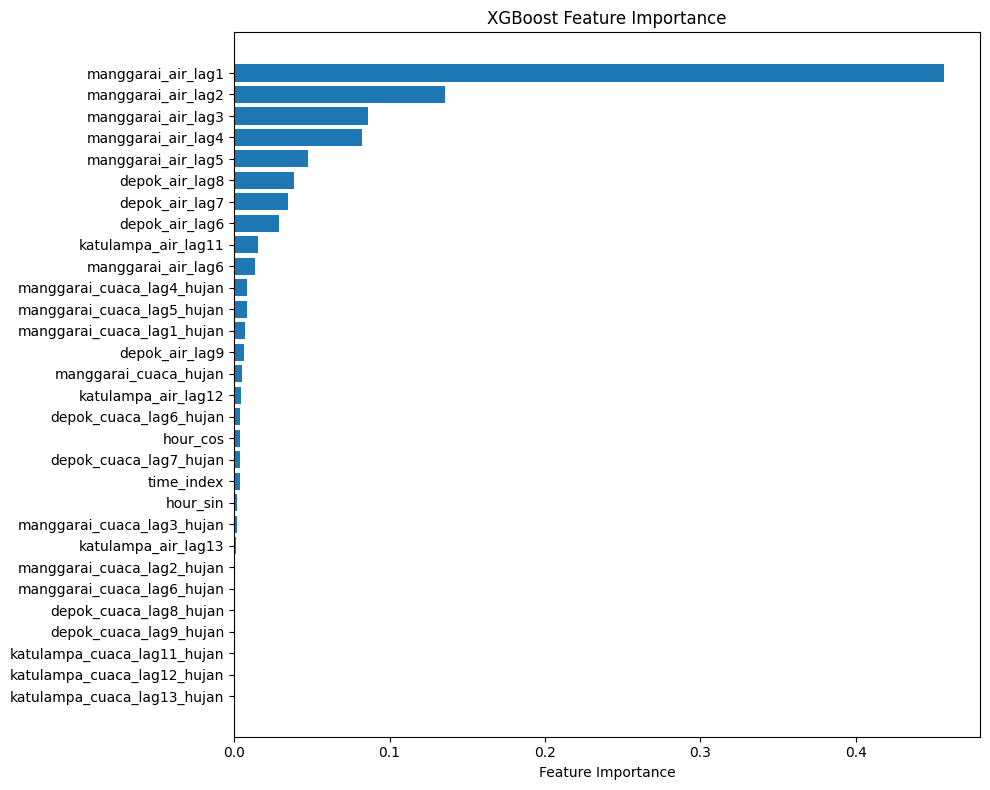

In [28]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': grid3_final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Most Important Features:")
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

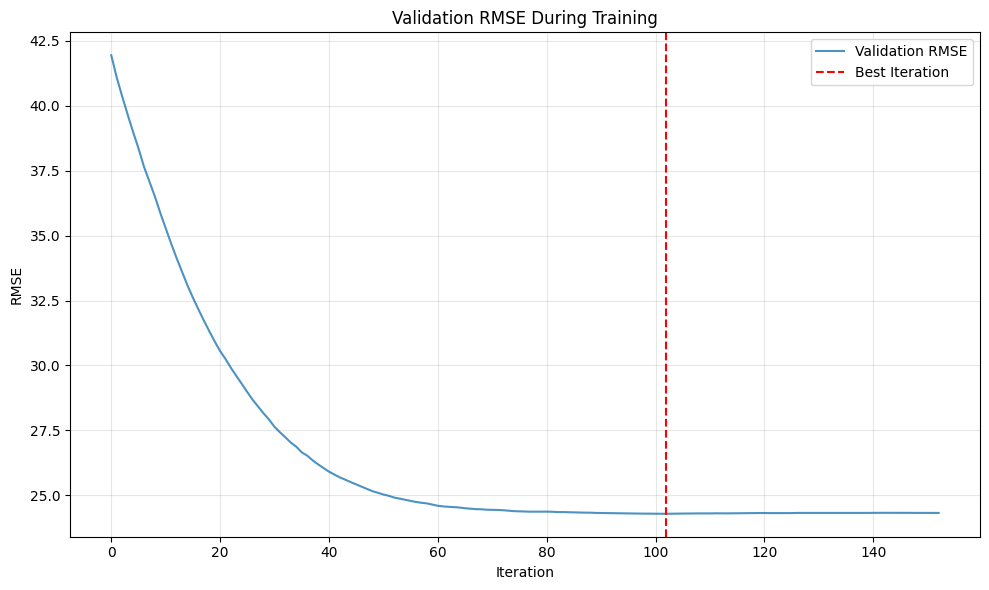

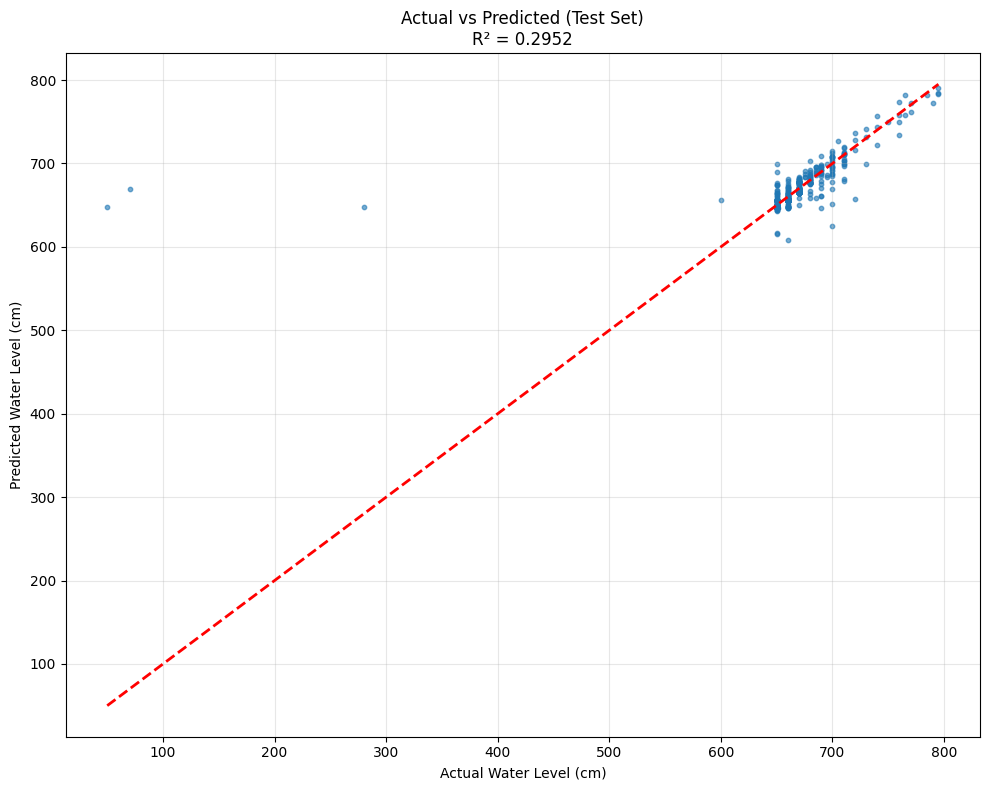

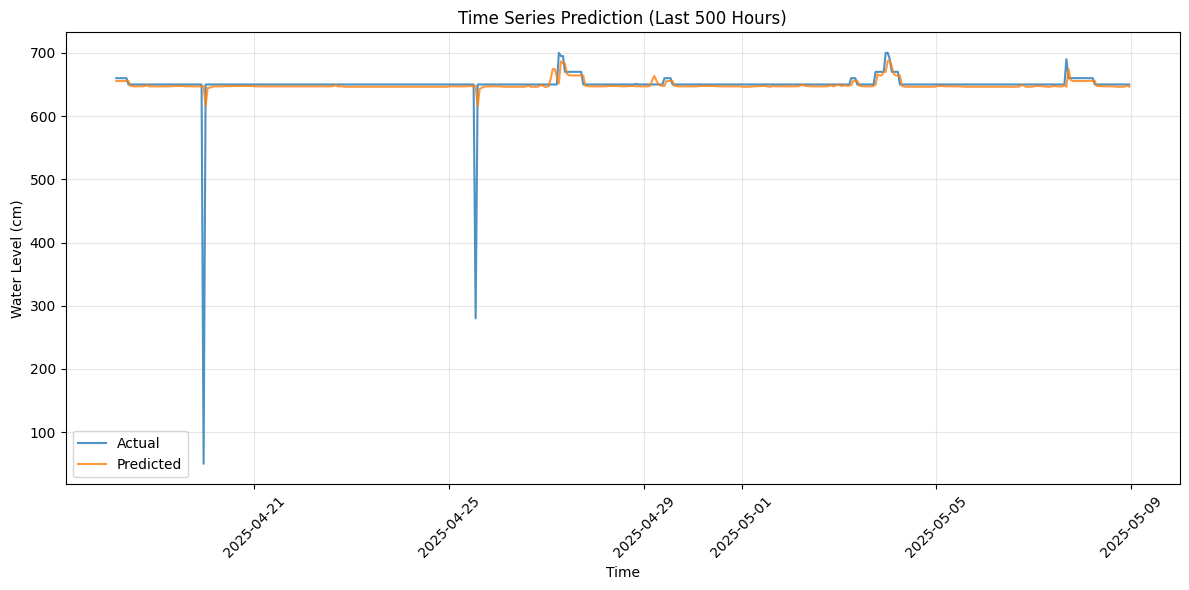

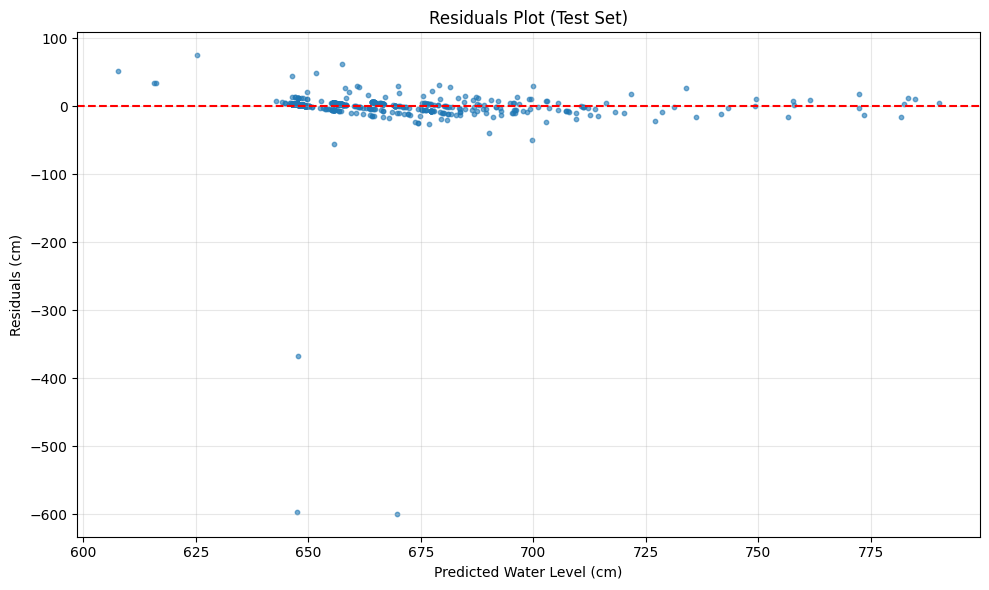

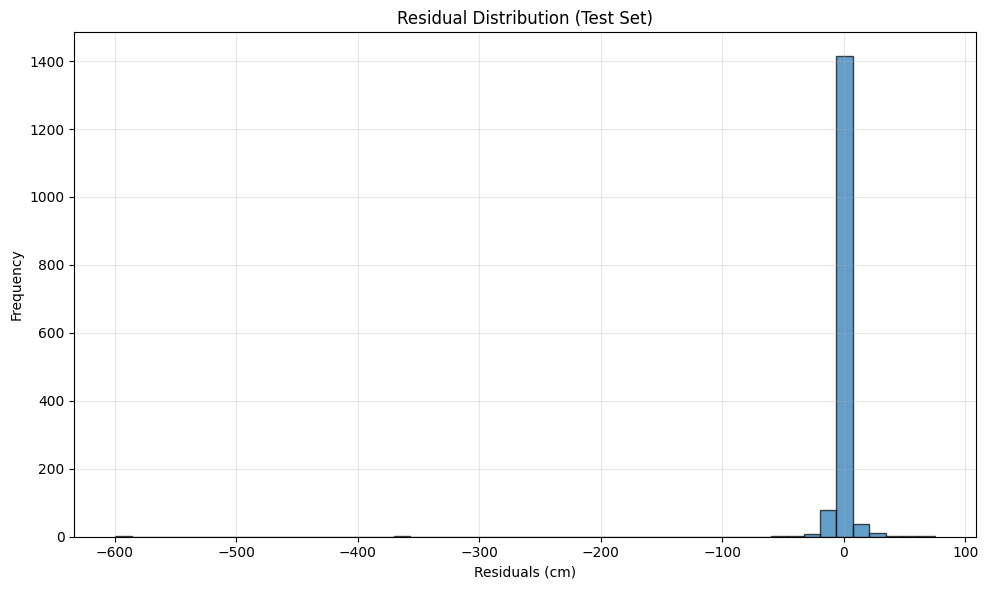

In [31]:
# =============================================================================
# PLOT 1: Training Validation Curve
# =============================================================================

plt.figure(figsize=(10, 6))
eval_results = grid3_final_model.evals_result()
if 'validation_0' in eval_results:
    plt.plot(eval_results['validation_0']['rmse'], label='Validation RMSE', alpha=0.8)
    plt.axvline(x=grid3_final_model.best_iteration, color='red', linestyle='--', label='Best Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Training progress\nnot available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Training Progress')

plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 2: Actual vs Predicted (Test Set)
# =============================================================================

plt.figure(figsize=(10, 8))
plt.scatter(y_test, test_pred_grid3, alpha=0.6, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Level (cm)')
plt.ylabel('Predicted Water Level (cm)')
plt.title(f'Actual vs Predicted (Test Set)\nR² = {test3_r2:.4f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 3: Time Series Prediction (Last 500 Points)
# =============================================================================

plt.figure(figsize=(12, 6))
plot_points = min(500, len(y_test))
plt.plot(y_test.tail(plot_points), label='Actual', linewidth=1.5, alpha=0.8)
plt.plot(y_test.tail(plot_points).index, test_pred_grid3[-plot_points:],
         label='Predicted', linewidth=1.5, alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Water Level (cm)')
plt.title(f'Time Series Prediction (Last {plot_points} Hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 4: Residuals Plot
# =============================================================================

plt.figure(figsize=(10, 6))
plt.scatter(test_pred_grid3, residuals_test, alpha=0.6, s=10)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Water Level (cm)')
plt.ylabel('Residuals (cm)')
plt.title('Residuals Plot (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 5: Residuals Histogram
# =============================================================================

plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (cm)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Reduced Dataset

In [ ]:
fixed_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1,
}

In [ ]:
baseline_start = datetime.now()
baseline_model = xgb.XGBRegressor(**fixed_params)
baseline_model.fit(X_train, y_train)
baseline_time = datetime.now() - baseline_start

baseline_train_pred = baseline_model.predict(X_train)
baseline_test_pred = baseline_model.predict(X_test)

# Calculate metrics for training set
baseline_train_rmse = np.sqrt(mean_squared_error(y_train, baseline_train_pred))
baseline_train_mae = mean_absolute_error(y_train, baseline_train_pred)
baseline_train_r2 = r2_score(y_train, baseline_train_pred)
baseline_train_mape = mean_absolute_percentage_error(y_train, baseline_train_pred)

# Calculate metrics for test set
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, baseline_test_pred))
baseline_test_mae = mean_absolute_error(y_test, baseline_test_pred)
baseline_test_r2 = r2_score(y_test, baseline_test_pred)
baseline_test_mape = mean_absolute_percentage_error(y_test, baseline_test_pred)

print(f"Baseline completed in {baseline_time}")

print(f"Baseline Train RMSE: {baseline_train_rmse:.4f}")
print(f"Baseline Train MAE: {baseline_train_mae:.4f}")
print(f"Baseline Train R2: {baseline_train_r2:.4f}")
print(f"Baseline Train MAPE: {baseline_train_mape:.4f}")

print(f"Baseline Test RMSE: {baseline_test_rmse:.4f}")
print(f"Baseline Test MAE: {baseline_test_mae:.4f}")
print(f"Baseline Test R2: {baseline_test_r2:.4f}")
print(f"Baseline Test MAPE: {baseline_test_mape:.4f}")

Baseline completed in 0:00:01.914691
Baseline Train RMSE: 10.4458
Baseline Train MAE: 2.9625
Baseline Train R2: 0.9470
Baseline Train MAPE: 0.0085
Baseline Test RMSE: 29.1520
Baseline Test MAE: 8.9603
Baseline Test R2: -0.0155
Baseline Test MAPE: 0.0259


# Grid Search

In [ ]:
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [300, 500],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.5, 1.0]
}

In [ ]:
combinations = 1
for param, values in param_grid.items():
    combinations *= len(values)
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {combinations}")

  max_depth: [4, 6, 8]
  min_child_weight: [1, 3]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]
  learning_rate: [0.05, 0.1, 0.15]
  n_estimators: [300, 500]
  reg_alpha: [0.1, 0.5]
  reg_lambda: [0.5, 1.0]

Total combinations: 576


In [ ]:
# Run grid search
base_model = xgb.XGBRegressor(**fixed_params)
grid_start = datetime.now()

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train, y_train)
grid_time = datetime.now() - grid_start

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300,

In [ ]:
print(f"Grid search time: {grid_time}")
print(f"Best grid CV score: {-grid_search.best_score_:.4f}")
print(f"Best grid parameters: {grid_search.best_params_}")

Grid search time: 0:22:28.614642
Best grid CV score: 16.8175
Best grid parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}


In [ ]:
grid_results_df = pd.DataFrame(grid_search.cv_results_)
grid_results_df.to_csv('08 grid_search_results.csv', index=False)

## Best Grid Search Level 2 Model Performance

In [ ]:
final_params = {**fixed_params, **grid_search.best_params_, 'early_stopping_rounds': 50}

print("Final parameters:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

Final parameters:
  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  random_state: 42
  n_jobs: -1
  verbosity: 1
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 4
  min_child_weight: 3
  n_estimators: 300
  reg_alpha: 0.5
  reg_lambda: 1.0
  subsample: 0.8
  early_stopping_rounds: 50


In [ ]:
# Train final model
final_start = datetime.now()
final_model = xgb.XGBRegressor(**final_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
final_training_time = datetime.now() - final_start

print(f"\nTraining completed in: {training_time}")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.4f}")


Training completed in: 0:00:00.826444
Best iteration: 27
Best score: 24.1459


In [ ]:
# Make predictions
train_pred = final_model.predict(X_train)
test_pred = final_model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)

print("TRAINING SET METRICS:")
print(f"  RMSE: {train_rmse:.4f} cm")
print(f"  MAE:  {train_mae:.4f} cm")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test_rmse:.4f} cm")
print(f"  MAE:  {test_mae:.4f} cm")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

TRAINING SET METRICS:
  RMSE: 16.5171 cm
  MAE:  4.9175 cm
  R²:   0.8676
  MAPE: 0.02%

TEST SET METRICS:
  RMSE: 24.1184 cm
  MAE:  5.3663 cm
  R²:   0.3049
  MAPE: 0.02%


In [ ]:
final_model.save_model('final_optimized_xgboost_model.json')